In [200]:
import numpy as np
import os
from keras.models import Model
from keras import layers
from keras.models import load_model
import pandas as pd
import lib.util as ut
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

## Load the model to be analyzed

In [201]:
model_path='./trained_models/model_paper/model_25epochs.h5'
model = load_model(model_path)
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/lib64/python3.6/site-packages/keras/legacy/layers.py:74: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24000, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24000, 64)         8320      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3000, 64)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 3000, 64, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3000, 64, 96)      5952      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 375, 64, 96)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 375, 64, 128)      430208    
__________

In [202]:
audio_path = "./data/audiodata"
labels_file = "./data/conflictlevel.csv"

intervals_seconds = 3
sample_rate = 8000

In [203]:
labels_df = pd.read_csv(labels_file, header=None)
labels_df["class"] = labels_df[1].apply(lambda x: 0 if x < 0 else 1)

In [204]:
train_df = pd.read_csv("./data/train_files.csv")
test_df = pd.read_csv("./data/test_files.csv")
validation_df = pd.read_csv("./data/validation_files.csv")

In [205]:
max_samples = 100
x_train,y_train=ut.get_chunks_from_raw(audio_path, train_df,max_samples,intervals_seconds=3,sample_rate=8000 )
x_test,y_test=ut.get_chunks_from_raw(audio_path, test_df,max_samples,intervals_seconds=3,sample_rate=8000 )
x_validation,y_validation=ut.get_chunks_from_raw(audio_path, validation_df,max_samples,intervals_seconds=3,sample_rate=8000  )


num_samples_train = len(x_train)
num_samples_test = len(x_test)
num_samples_validation = len(x_validation)

reading file 06-05-03_600_630.wav
reading file 07-02-28_1890_1920.wav
reading file 06-05-24_1290_1320.wav
file 06-04-12_1110_1140.wav not in the dataframe
reading file 07-10-31_2310_2340.wav
file 06-05-03_600_630.wav not in the dataframe
file 07-02-28_1890_1920.wav not in the dataframe
file 06-05-24_1290_1320.wav not in the dataframe
reading file 06-04-12_1110_1140.wav
file 07-10-31_2310_2340.wav not in the dataframe
reading file 07-02-21_750_780.wav
file 07-02-14_270_300.wav not in the dataframe
file 06-11-22_1740_1770.wav not in the dataframe
reading file 06-11-08_480_510.wav
file 07-09-17_540_570.wav not in the dataframe
file 07-02-21_2070_2100.wav not in the dataframe
file 06-09-13_2190_2220.wav not in the dataframe
file 07-02-14_2190_2220.wav not in the dataframe
file 08-02-06_1380_1410.wav not in the dataframe
file 06-04-05_1200_1230.wav not in the dataframe
file 07-10-31_2280_2310.wav not in the dataframe
file 06-04-12_2040_2070.wav not in the dataframe
file 07-02-28_1980_2010.w

In [206]:
# Layers we want to analyze
num_layers = 20
layer_outputs = [layer.output for layer in model.layers[5:11]] 
# Build a model to obtain the output of layers of interest
# Creates a model that will return these outputs, given the model input
activation_model = Model(inputs=model.input, outputs=layer_outputs) #

In [207]:
# Predict a sample  to visualize activations
# sample 8 -> positive, 5-> negative
x_arr = x_train[8].reshape([1,24000,1])
y_arr = np.array(y_train[8])
activations=activation_model.predict(x_arr)
print(model.predict(x_arr))


[[0.99999857]]


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


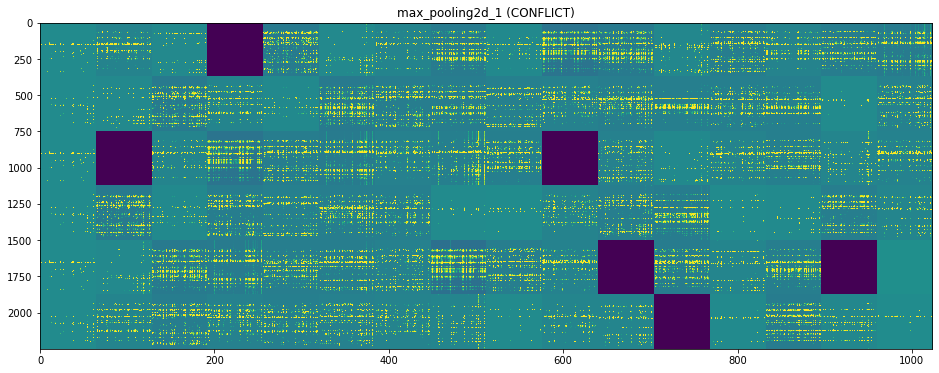

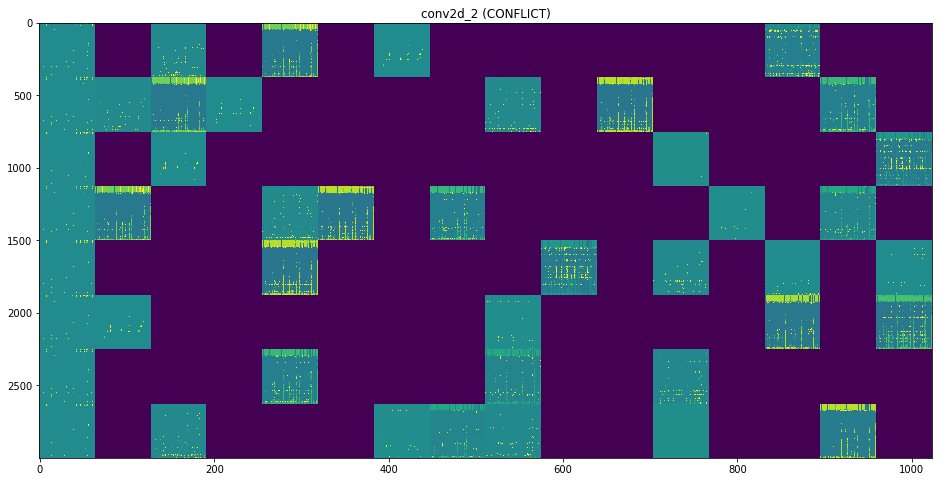

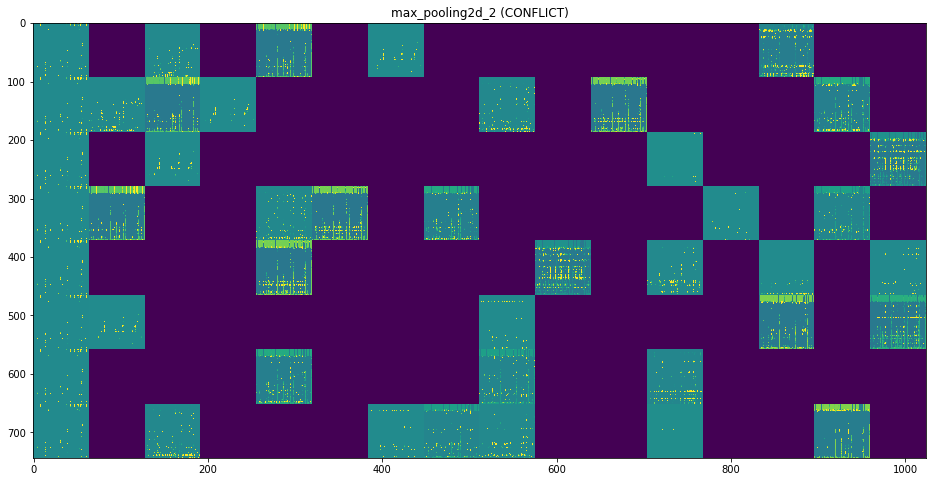

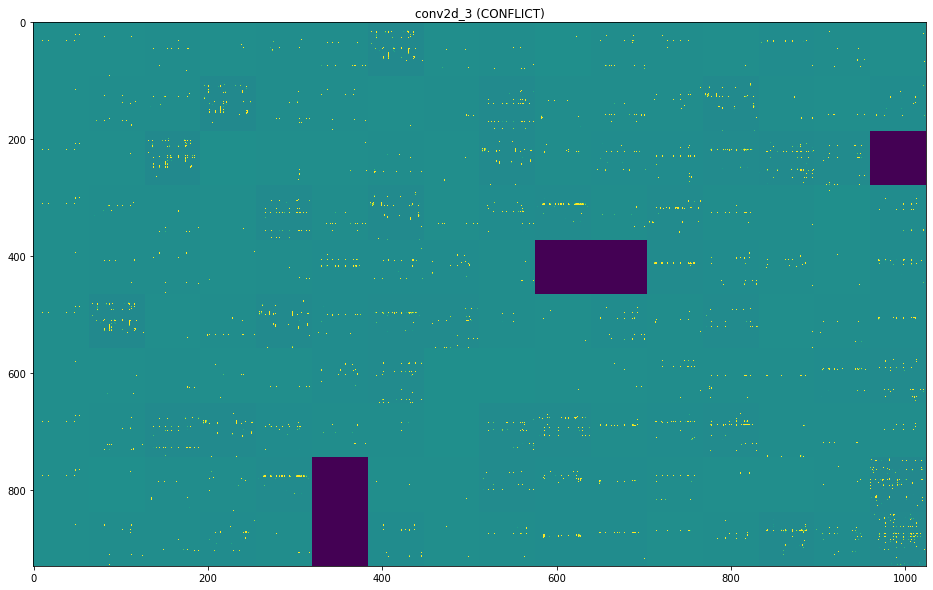

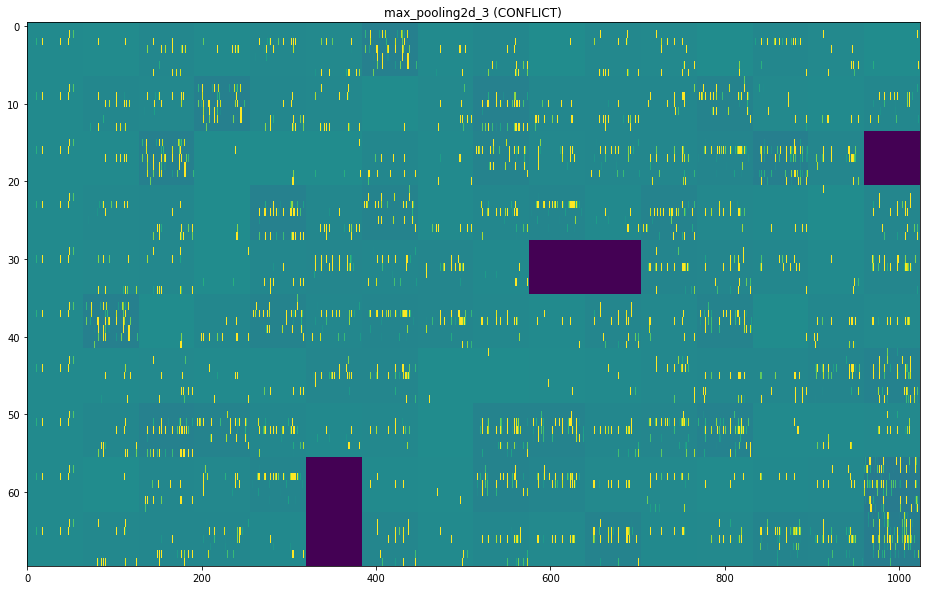

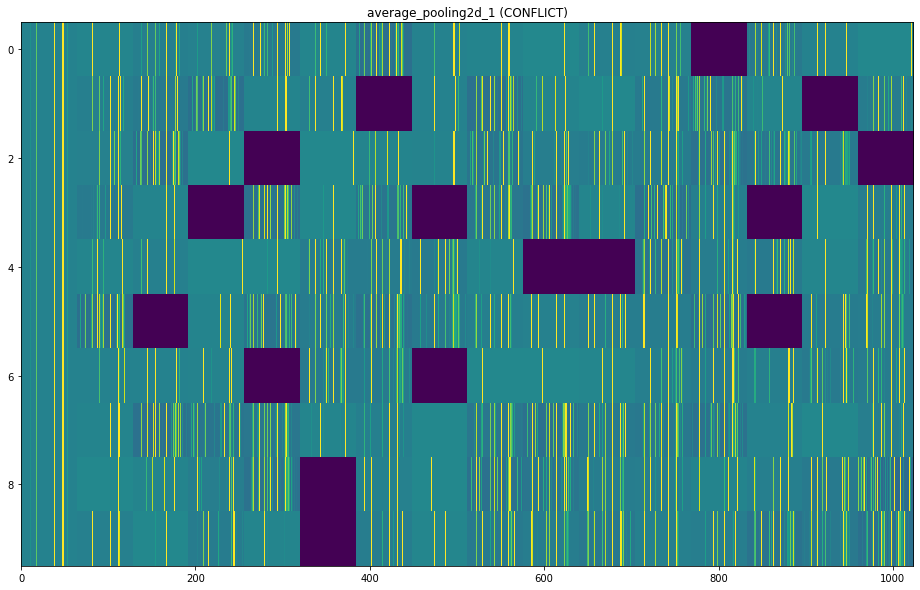

In [208]:
subTitle = " (CONFLICT)"
layer_names = []
for layer in model.layers[5:11]:
    layer_names.append(layer.name) 
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size_x = layer_activation.shape[2] #The feature map has shape (1, size_x, size_y, n_features).
    size_y = layer_activation.shape[1] #The feature map has shape (1, size_x, size_y, n_features).
    n_rows = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((n_rows * size_y,size_x * images_per_row))
    for row in range(n_rows): # Tiles each filter into a big horizontal grid

        for col in range(images_per_row):
            channel_image = layer_activation[0,
                                              :,:,
                                             row * col + col]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            display_grid[row * size_y : (row + 1) * size_y,
                         col * size_x : (col + 1) * size_x] = channel_image
    scale_x = 1. / size_x
    scale_y = 1. / size_y

    
    plt.figure(figsize=(scale_x * display_grid.shape[1],
                        scale_y * display_grid.shape[0]))

    plt.title(layer_name+subTitle)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')